In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from kerashypetune import KerasGridSearch

In [2]:
df = pd.read_csv('temp.csv', sep=';')
df = df.dropna()

print(df.shape)
df.head()

(8760, 3)


,Data,Ora solare,Livello P.Salute Canal Grande (cm)
0,01-gen-09,01:00,34.0
1,01-gen-09,02:00,37.0
2,01-gen-09,03:00,36.0
3,01-gen-09,04:00,29.0
4,01-gen-09,05:00,20.0


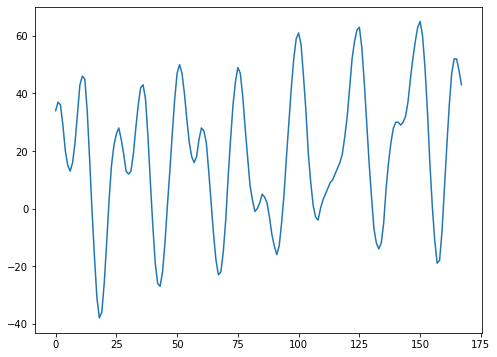

In [3]:

df[:7*24]['Livello P.Salute Canal Grande (cm)'].plot(y='Livello P.Salute Canal Grande (cm)', x='Ora solare', figsize=(8,6))


In [4]:
class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [5]:
sequence_length = 24

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [6]:

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def T2V_NN(param, dim):
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m


def NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(param['unit'])(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

In [7]:

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    Y.append(sequence)
X = np.asarray(X)
Y = np.asarray(Y)


# X.shape, Y.shape, X[1], X[2]

In [8]:

X.shape, Y.shape

((8736, 24, 1), (8736, 1))

In [9]:
train_dim = int(0.7*len(df))
X_train, X_test = X[:train_dim], X[train_dim:]
y_train, y_test = Y[:train_dim], Y[train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6132, 24, 1) (6132, 1)
(2604, 24, 1) (2604, 1)


In [10]:
param_grid = {
    'unit': [64],
    't2v_dim': [128],
    'lr': [1e-3], 
#     'act': ['relu'], 
    'epochs': 200,
    'batch_size': [512]
}

In [11]:
es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: T2V_NN(param=x, dim=sequence_length)

kgs_t2v = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs_t2v.set_seed(set_seed_TF2, seed=33)
kgs_t2v.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)


1 trials detected for ('unit', 't2v_dim', 'lr', 'epochs', 'batch_size')

***** (1/1) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 14.00076 at epoch 200
